# Notebook 1: Introduction to Multi-Armed Bandits
## 1. Introduction

Welcome to the first notebook in our multi-armed bandit tutorial series! In this notebook, we will:

1. Define the *k*-armed bandit problem.
2. Implement a simple *k*-armed bandit environment using Python.
3. Demonstrate two basic action selection strategies:
   - Greedy action selection
   - \(\epsilon\)-greedy action selection
4. Run experiments to compare their performance.

By the end of this notebook, you should have a solid understanding of the exploration-exploitation dilemma and how these two strategies address it.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline

class KArmedBandit:
    def __init__(self, k=10, mu_mean=0.0, mu_std=1.0):
        self.k = k
        self.true_means = np.random.normal(mu_mean, mu_std, k)

    def pull_arm(self, arm_index):
        true_mean = self.true_means[arm_index]
        reward = np.random.normal(true_mean, 1.0)
        return reward

    def reset(self):
        self.true_means = np.random.normal(0.0, 1.0, self.k)

In [41]:
def run_bandit_experiment(env, num_steps, strategy="greedy", epsilon=0.1):
    k = env.k
    Q = np.zeros(k)
    N = np.zeros(k)
    true_means = env.true_means
    optimal_arm = np.argmax(true_means)

    rewards = np.zeros(num_steps)
    optimal_actions = np.zeros(num_steps, dtype=bool)

    for t in range(num_steps):
        if strategy == "greedy":
            action = np.argmax(Q)
        elif strategy == "epsilon_greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.argmax(Q)
        else:
            raise ValueError("Unsupported strategy. Choose 'greedy' or 'epsilon_greedy'.")

        reward = env.pull_arm(action)

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]

        rewards[t] = reward
        optimal_actions[t] = (action == optimal_arm)

    return rewards, optimal_actions

In [42]:
def compare_strategies(k=10, num_steps=1000, num_runs=2000, epsilons=[0.1]):
    average_rewards = {}
    optimal_action_perc = {}

    strategies = ["greedy"] + [f"epsilon={eps}" for eps in epsilons]

    for strategy in strategies:
        all_rewards = np.zeros((num_runs, num_steps))
        all_optimal_actions = np.zeros((num_runs, num_steps), dtype=bool)

        for run in range(num_runs):
            env = KArmedBandit(k=k)

            if strategy == "greedy":
                rewards, optimal_actions = run_bandit_experiment(env, num_steps, strategy="greedy")
            else:
                eps_value = float(strategy.split("=")[1])
                rewards, optimal_actions = run_bandit_experiment(env, num_steps,
                                                                 strategy="epsilon_greedy",
                                                                 epsilon=eps_value)

            all_rewards[run, :] = rewards
            all_optimal_actions[run, :] = optimal_actions

        mean_rewards = all_rewards.mean(axis=0)
        mean_optimal = all_optimal_actions.mean(axis=0)

        average_rewards[strategy] = mean_rewards
        optimal_action_perc[strategy] = mean_optimal

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    for strategy in strategies:
        plt.plot(average_rewards[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward over Time")
    plt.legend()
    plt.subplot(1, 2, 2)
    for strategy in strategies:
        plt.plot(100 * optimal_action_perc[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title("Optimal Action Percentage over Time")
    plt.legend()

    plt.show()

    return average_rewards, optimal_action_perc

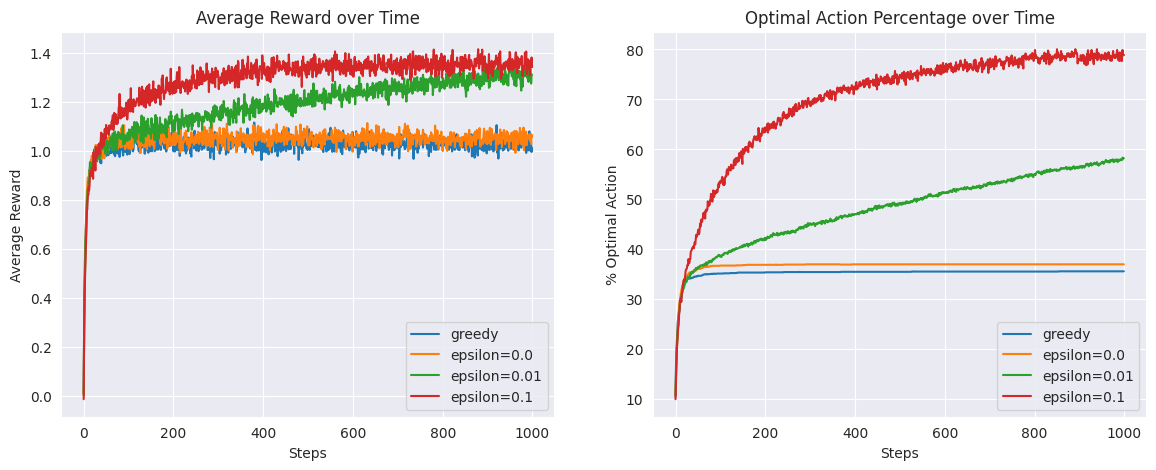

In [43]:
epsilons_to_test = [0.0, 0.01, 0.1]

avg_rewards, opt_actions = compare_strategies(
    k=10,
    num_steps=1000,
    num_runs=2000,
    epsilons=epsilons_to_test
)

In [44]:
def find_optimal_epsilon(k=10, num_steps=1000, num_runs=2000, epsilon_range=np.arange(0.0, 0.31, 0.01)):
    average_rewards = {}
    optimal_action_perc = {}

    strategies = [f"epsilon={eps}" for eps in epsilon_range]

    for strategy in strategies:
        eps_value = float(strategy.split("=")[1])
        all_rewards = np.zeros((num_runs, num_steps))
        all_optimal_actions = np.zeros((num_runs, num_steps), dtype=bool)

        for run in range(num_runs):
            env = KArmedBandit(k=k)
            rewards, optimal_actions = run_bandit_experiment(env, num_steps,
                                                             strategy="epsilon_greedy",
                                                             epsilon=eps_value)
            all_rewards[run, :] = rewards
            all_optimal_actions[run, :] = optimal_actions

        mean_rewards = all_rewards.mean(axis=0)
        mean_optimal = all_optimal_actions.mean(axis=0)

        average_rewards[strategy] = mean_rewards
        optimal_action_perc[strategy] = mean_optimal

    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        plt.plot(average_rewards[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title("Average Reward over Time for Different Epsilon Values")
    plt.legend(ncol=5, fontsize='small')
    plt.show()

    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        plt.plot(100 * optimal_action_perc[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title("Optimal Action Percentage over Time for Different Epsilon Values")
    plt.legend(ncol=5, fontsize='small')
    plt.show()

    return average_rewards, optimal_action_perc

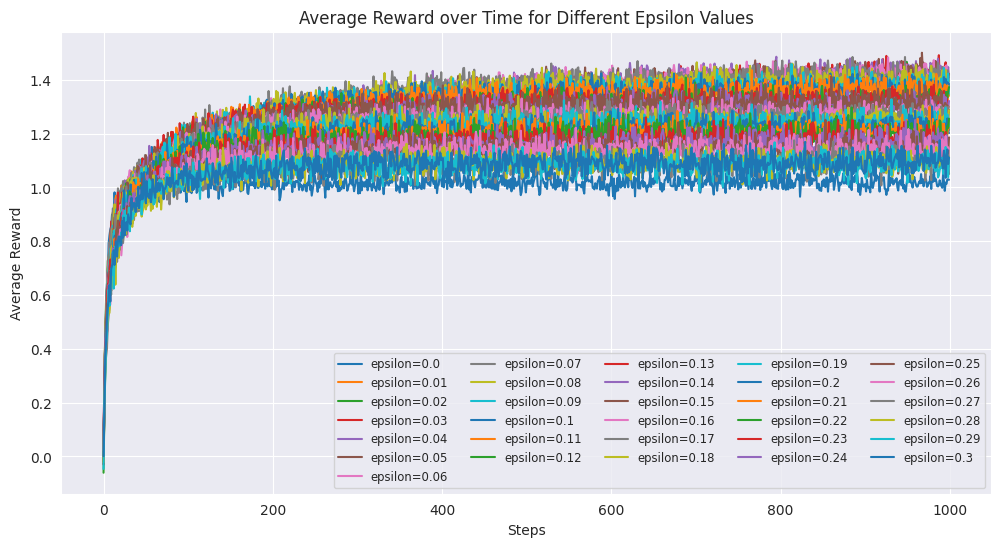

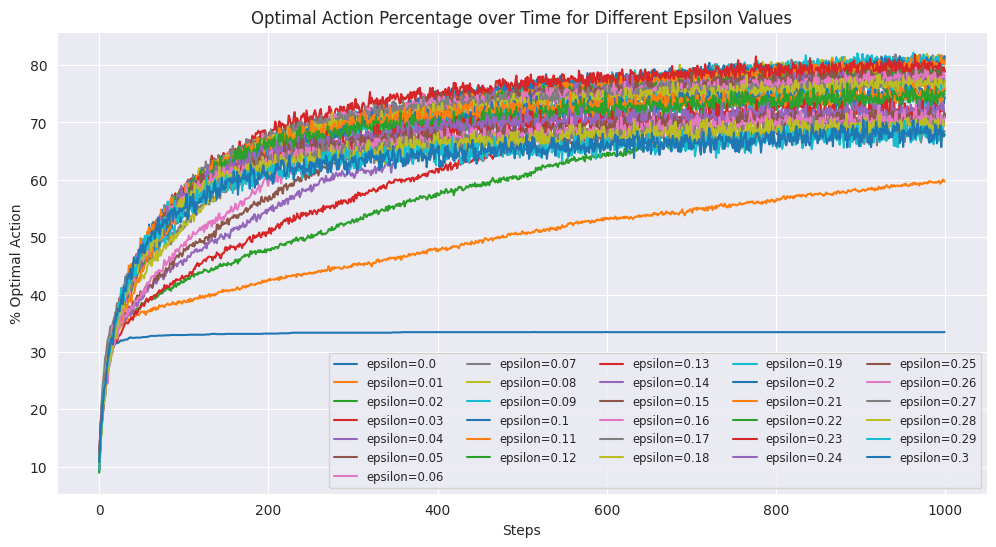

In [45]:
epsilon_values = np.arange(0.0, 0.31, 0.01)

avg_rewards_epsilon, opt_actions_epsilon = find_optimal_epsilon(
    k=10,
    num_steps=1000,
    num_runs=2000,
    epsilon_range=epsilon_values
)

In [48]:
@widgets.interact(
    epsilon=widgets.FloatSlider(min=0.0, max=0.3, step=0.01, value=0.1, description='Epsilon'),
    num_runs=widgets.IntSlider(min=100, max=5000, step=100, value=1000, description='Num Runs'),
    num_steps=widgets.IntSlider(min=100, max=5000, step=100, value=1000, description='Num Steps')
)
def interactive_epsilon_greedy(epsilon, num_runs, num_steps):
    strategies = ["greedy", f"epsilon={epsilon}"]

    average_rewards = {}
    optimal_action_perc = {}

    for strategy in strategies:
        if strategy == "greedy":
            eps_val = None
        else:
            eps_val = epsilon

        all_rewards = np.zeros((num_runs, num_steps))
        all_optimal_actions = np.zeros((num_runs, num_steps), dtype=bool)

        for run in range(num_runs):
            env = KArmedBandit(k=10)

            if strategy == "greedy":
                rewards, optimal_actions = run_bandit_experiment(env, num_steps, strategy="greedy")
            else:
                rewards, optimal_actions = run_bandit_experiment(env, num_steps,
                                                                 strategy="epsilon_greedy",
                                                                 epsilon=eps_val)

            all_rewards[run, :] = rewards
            all_optimal_actions[run, :] = optimal_actions

        mean_rewards = all_rewards.mean(axis=0)
        mean_optimal = all_optimal_actions.mean(axis=0)

        average_rewards[strategy] = mean_rewards
        optimal_action_perc[strategy] = mean_optimal

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    for strategy in strategies:
        plt.plot(average_rewards[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title(f"Average Reward over Time (Epsilon={epsilon})")
    plt.legend()
    plt.subplot(1, 2, 2)
    for strategy in strategies:
        plt.plot(100 * optimal_action_perc[strategy], label=strategy)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.title(f"Optimal Action Percentage over Time (Epsilon={epsilon})")
    plt.legend()

    plt.show()

interactive(children=(FloatSlider(value=0.1, description='Epsilon', max=0.3, step=0.01), IntSlider(value=1000,…